In [ ]:
import cv2
import matplotlib.pyplot as plt
from matplotlib.colors import hsv_to_rgb
import numpy as np
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import time 
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Conv2DTranspose # = Deconvolution2D
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import concatenate
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os
import time
from imagePreprocess import getImagesVarAndMean

In [ ]:
# TODO:
# find how to use multithreading in jupyter on windows
# less green
%load_ext blackcellmagic
dataDir = "data/resized/"
biggerNet = False
depthMultiplier = 2
initializer = 'he_normal'#'glorot_uniform'

In [ ]:
def showHsv(img):    
    img = cv2.cvtColor(img, cv2.COLOR_HSV2RGB)
    plt.imshow(img)
    plt.show()

In [ ]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
img_in = cv2.imread('pic.jpg')
# maybe should switch to LAB colorspace?
hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
print(hsv.shape)

h,s,v = cv2.split(hsv)
#print('s',s.shape)
s = (np.random.random(s.shape) * 255).astype('uint8')
h = (np.random.random(s.shape) * 255).astype('uint8')
#s = np.maximum(0, v)
#print(s)
hsv = cv2.merge([h,s,v])
# print('image with its value untouched, but saturation and hue randomized:');showHsv(hsv)

In [5]:
def loadImgHsv(path):
    '''
    returns X - value
            Y - (hue, saturation)
    '''
    img_in = cv2.imread(path)
    hsv = cv2.cvtColor(img_in, cv2.COLOR_BGR2HSV)
    h,s,v = cv2.split(hsv)
    X = v
    Y = np.dstack((h,s))
    #print("loadX.shape", X.shape, 'loadY.shape', Y.shape)
    return X, Y

# celebA dataset from https://drive.google.com/drive/folders/0B7EVK8r0v71pTUZsaXdaSnZBZzg
# 202,599 images of size 178x218
# in /resized/ they are cropped to be 128x128

# data generator for feeding into memory parts of dataset
class DataGenerator(tf.keras.utils.Sequence):
    'data generator for feeding into memory parts of dataset'
    def __init__(self, list_IDs, dim, var, mean, batch_size=32, in_channels=1,
                 out_channels=2, shuffle=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.shuffle = shuffle
        self.on_epoch_end()
        self.hsstd = np.sqrt(var[...,:2])
        self.hsmean = mean[...,:2]
        self.vstd = np.sqrt(var[...,2])
        self.vmean = mean[...,2]

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(list_IDs_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim))
        # target 2 channels
        Y = np.empty((self.batch_size, *self.dim, self.out_channels))
        # print(X.shape, Y.shape)
        # Generate data
        for i, ID in enumerate(list_IDs_temp):
            # Store sample
            X[i], Y[i] = loadImgHsv(dataDir + ID)
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        #X = (X - self.vmean)/self.vstd
        X = np.expand_dims(X, axis=len(X.shape))
#         print('X[i].shape:',X[0].shape)
#         print('X.shape:',X.shape,'Y.shape',Y.shape)
        return X, Y

In [6]:
params = {'dim': (128, 128),
          'batch_size': 64,
          'in_channels': 1,
          'out_channels': 2,
          'shuffle': True}
data_IDs = os.listdir(dataDir)
print('dataset size',len(data_IDs))
trainSplitPercent = 0.1
trainSize = int(len(data_IDs)*trainSplitPercent)
train_IDs = data_IDs[:trainSize]
print('train len', len(train_IDs))
valSplitPercent = 0.02
valSize = int(len(data_IDs)*valSplitPercent)
splitValAt = int(trainSize + valSize)
val_IDs = data_IDs[trainSize:splitValAt]
print('val len', len(val_IDs))

params['var'], params['mean'] = getImagesVarAndMean([dataDir + x for x in train_IDs], params['dim'] + (3,))


training_generator = DataGenerator(train_IDs, **params)
validation_generator = DataGenerator(val_IDs, **params)
print(training_generator[0][1].shape)

dataset size 202599
train len 20259
val len 4051
(64, 128, 128, 2)


In [68]:
def createModel(input_shape, bigger, mul, initializer):
    input_shape = input_shape + (1,)
    inputs = Input(input_shape)
    
    conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(inputs)
    if bigger:
        conv1 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(pool1)
    if bigger:
        conv2 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(pool2)
    if bigger:
        conv3 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    
    conv4 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(pool3)
    if bigger:
        conv4 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv4)
    
    up5 = Conv2D(64*mul, 2, activation = 'relu', padding = 'same')(UpSampling2D(size = (2,2))(conv4))
    merge5 = concatenate([conv3, up5], axis=3)
    conv5 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(merge5)
    if bigger:
        conv5 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv5)
    
    up6 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv5))
    merge6 = concatenate([conv2, up6], axis=3)
    conv6 = Conv2D(32*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(merge6)
    if bigger:
        conv6 = Conv2D(64*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv6)
    
    up7 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv1, up7], axis=3)
    conv7 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(merge7)
    if bigger:
        conv7 = Conv2D(16*mul, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv7)
    conv7 = Conv2D(4, 3, activation = 'relu', padding = 'same', kernel_initializer=initializer)(conv7)
    # todo change to sigmoid?
    # Stride 1 deconvolutions — which we often see as the last layer in successful models 
    conv7 = Conv2D(2, 1, activation = 'relu', kernel_initializer=initializer)(conv7)
    
    model = Model(inputs=inputs, outputs=conv7)
    
    model.compile(loss='mean_squared_error',#customLoss, 
                  optimizer='adam',#tf.keras.optimizers.Adam(lr=0.001),
                  metrics=['mae','mse'])
    return model

model = createModel(params['dim'], biggerNet, depthMultiplier, initializer)
model.summary()
print(model.output_shape)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 128, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_48 (Conv2D)              (None, 128, 128, 32) 320         input_5[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_12 (MaxPooling2D) (None, 64, 64, 32)   0           conv2d_48[0][0]                  
__________________________________________________________________________________________________
conv2d_49 (Conv2D)              (None, 64, 64, 64)   18496       max_pooling2d_12[0][0]           
__________________________________________________________________________________________________
max_poolin

In [ ]:
currTime = time.strftime("%d-%m-%Y-%H-%M-%S", time.localtime())
layers = ['unet', 'bigger' if biggerNet else 'smaller', f'mul{depthMultiplier}', initializer]
NAME = "_".join(str(l) for l in layers) + f"{ currTime }"
print(NAME)
model = createModel(params['dim'], biggerNet, depthMultiplier, initializer)
tensorboard = TensorBoard(log_dir=f'logs/{NAME}')
model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    epochs=1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
countEpochs = 1

unet_smaller_mul2_he_normal12-05-2019-19-47-29
Epoch 1/1
187/316 [================>.............] - ETA: 41s - loss: 4877.1543 - mean_absolute_error: 48.0474 - mean_squared_error: 4877.1543

Epoch 2/2
316/316 [==============================] - 107s 340ms/step - loss: 3766.4473 - mean_absolute_error: 42.5944 - mean_squared_error: 3766.4473 - val_loss: 3671.9144 - val_mean_absolute_error: 41.4610 - val_mean_squared_error: 3671.9144
elapsed time: 107.90615892410278
predy 0.0 201.28871 49.572575 (1, 128, 128, 2)
hue: 0.0 111.09195 2.068749
sat: 31.8452 201.28871 97.0764
predy uint8 0 201 49.31536865234375
hue uint8 35 101 69.3359375


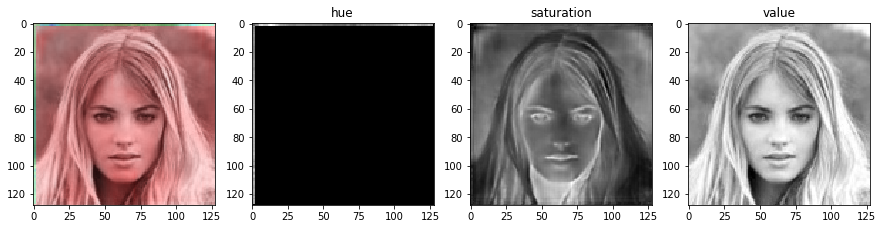

Epoch 3/3
 25/316 [=>............................] - ETA: 1:29 - loss: 3719.0549 - mean_absolute_error: 41.9297 - mean_squared_error: 3719.0550

KeyboardInterrupt: 

In [18]:
for i in range(1,5):
    start_time = time.time()
    model.fit_generator(generator=training_generator,
                    validation_data=validation_generator,
                    initial_epoch=countEpochs, # for tensorflow graph continuation
                    epochs=countEpochs+1,
                    use_multiprocessing=False,
                    workers=0,
                    callbacks=[tensorboard])
    countEpochs+=1
    elapsed_time = time.time() - start_time
    print("elapsed time:",elapsed_time)
    predictFromImage(f'data/resized/{i+18:06}.jpg', True)

In [10]:
def showImgFromPredict(hs, v, showDetails=False):
    '''shows h/s/v and complete image
    hs- a list containing hue and saturation matrices
    v - value matrix.
    all three should be uint8
    '''
    hs, v = hs[0], v[0,...,0]
#     print('hs:',hs.shape)
    h, s = hs[...,0], hs[...,1]
    #print('h',h.shape,'s',s.shape,'v',v.shape)
    #print(h.dtype, s.dtype, v.dtype)
    hsv = cv2.merge([h,s,v])
    # showHsv(hsv)    
    img = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
    if not showDetails:
        plt.imshow(img)
        plt.show()
        return
    
    f, axarr = plt.subplots(1,4, figsize=(15,15))
    
    axarr[0].imshow(img)
    for i in range(2,-1,-1):
        pic = hsv[:,:,i]
        #axarr.title(['hue', 'saturation', 'value'][i])
        axarr[1+i].title.set_text(['hue', 'saturation', 'value'][i])
        axarr[1+i].imshow(pic, cmap='gray')
    plt.show()
    
def predictFromImage(img, showDetails=False):
    '''processes input img, makes prediction from its value,
    and shows resulting image, hue, saturation and value'''
    X, Y = validation_generator[1]
    #print('xshape',X.shape, 'yshape',Y.shape)

    inX, inY = loadImgHsv(img )
    inX, inY = inX[None,...,None], inY[None,:]
    X, Y = X[10][None,:], Y[0][None,:]

    X, Y = inX, inY
    # 1st layer is hue, 2nd saturation
    predY = model.predict(X)

    print('predy',predY.min(), predY.max(), predY.mean() ,predY.shape)
    print('hue:',predY[...,0].min(), predY[...,0].max(), predY[...,0].mean() )
    print('sat:',predY[...,1].min(), predY[...,1].max(), predY[...,1].mean() )
    predY = predY
    predY = np.maximum(predY, 0)
    X = X.astype('uint8')
    predY = predY.astype('uint8')
    print('predy uint8',predY.min(), predY.max(), predY.mean() )
    #predY[:,0] += 0
    #predY[0,0] = 0
    hue = predY[:,0]
    print('hue uint8',hue.min(), hue.max(), hue.mean() )

    showImgFromPredict(predY, X, showDetails)
    
def predictions(start=trainSize+98, count=10):
    '''display count predictionst, beginning from start'''
    for i in range(start,start+count):
        predictFromImage(f'data/resized/{i:06}.jpg', True)

countEpochs 1
predy 0.0 178.76308 35.880196 (1, 128, 128, 2)
hue: 0.0 89.43511 1.6474392
sat: 0.027763093 178.76308 70.112946
predy uint8 0 178 35.621490478515625
hue uint8 0 103 52.58203125


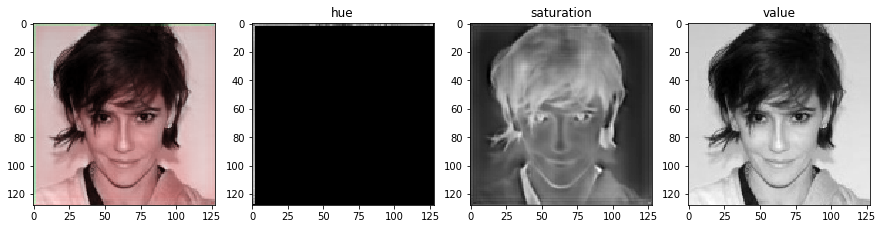

predy 0.0 177.22308 44.284794 (1, 128, 128, 2)
hue: 0.0 79.354065 1.6844327
sat: 7.411949 177.22308 86.885155
predy uint8 0 177 44.027435302734375
hue uint8 0 136 65.359375


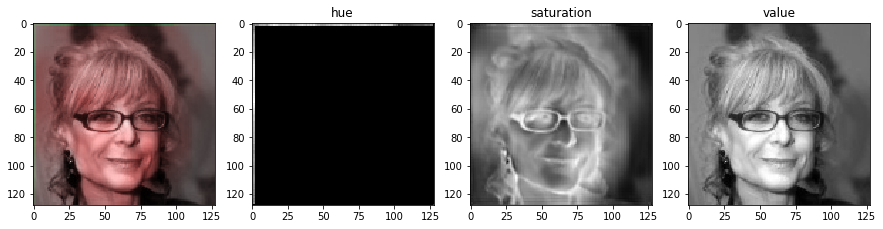

predy 0.0 176.51347 52.817535 (1, 128, 128, 2)
hue: 0.0 90.87577 1.4459186
sat: 6.935003 176.51347 104.18915
predy uint8 0 176 52.559112548828125
hue uint8 0 162 71.484375


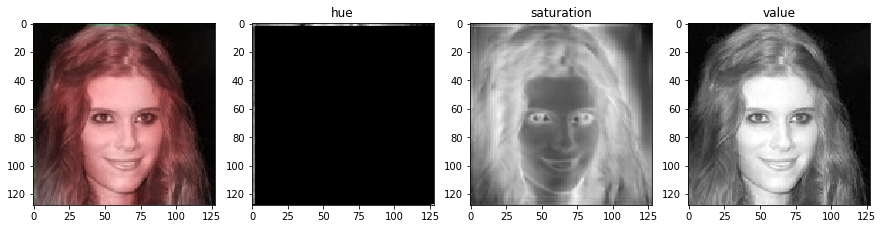

predy 0.0 199.01984 47.856888 (1, 128, 128, 2)
hue: 0.0 78.665825 1.2594233
sat: 5.9630055 199.01984 94.45436
predy uint8 0 199 47.600341796875
hue uint8 0 82 40.69921875


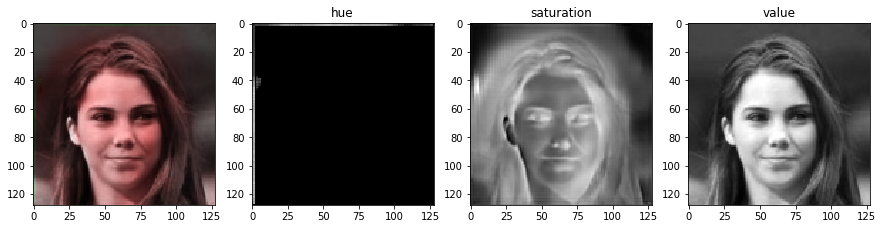

predy 0.0 188.17662 43.98141 (1, 128, 128, 2)
hue: 0.0 84.55804 1.9376688
sat: 20.00296 188.17662 86.02516
predy uint8 0 188 43.72296142578125
hue uint8 0 84 57.90234375


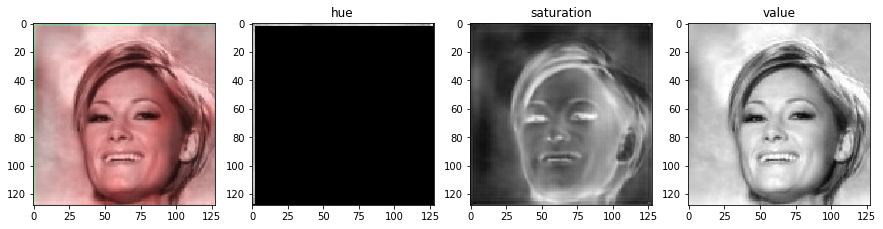

predy 0.0 172.95956 48.294575 (1, 128, 128, 2)
hue: 0.0 60.17804 1.0105838
sat: 1.5663412 172.95956 95.57857
predy uint8 0 172 48.034576416015625
hue uint8 0 103 48.63671875


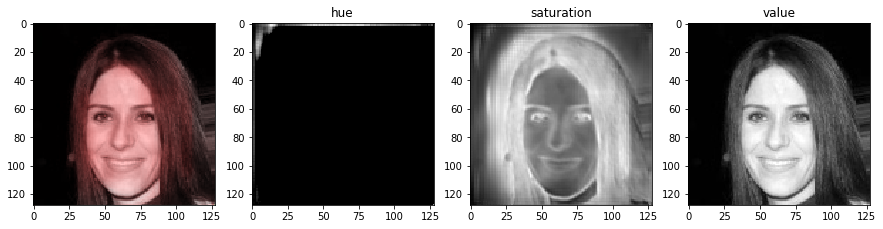

predy 0.0 171.0486 40.719864 (1, 128, 128, 2)
hue: 0.0 86.66949 1.5622742
sat: 0.79948497 171.0486 79.87746
predy uint8 0 171 40.46343994140625
hue uint8 0 123 59.5390625


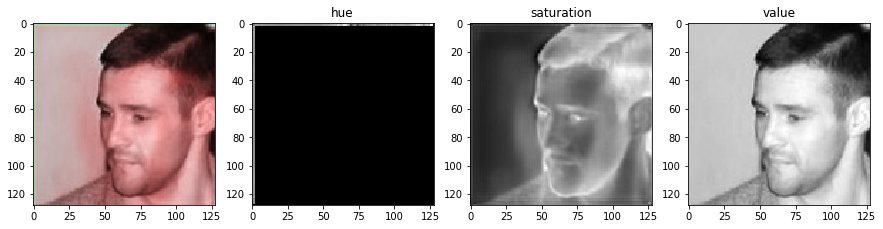

predy 0.0 213.3574 57.516243 (1, 128, 128, 2)
hue: 0.0 160.20087 2.0188344
sat: 12.100923 213.3574 113.01365
predy uint8 0 213 57.258697509765625
hue uint8 0 173 83.359375


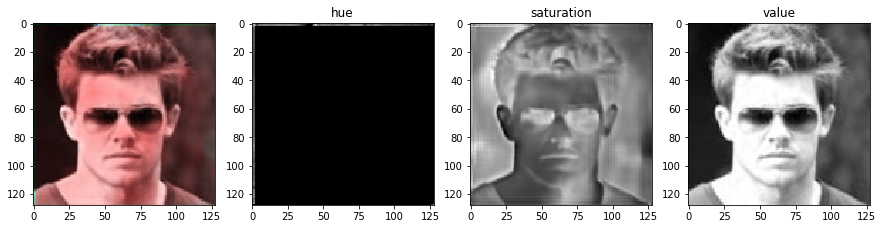

predy 0.0 230.40724 45.25527 (1, 128, 128, 2)
hue: 0.0 130.96494 1.9185263
sat: 0.027763093 230.40724 88.592
predy uint8 0 230 44.998992919921875
hue uint8 0 181 78.984375


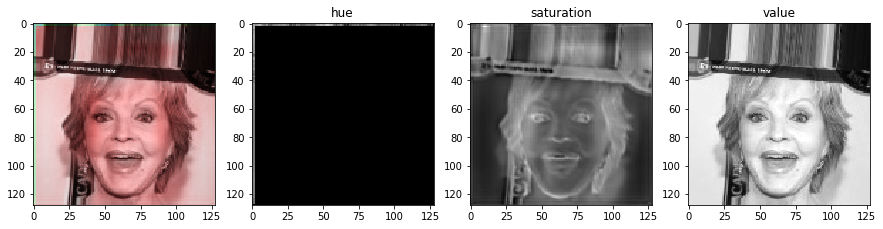

predy 0.0 187.37305 44.31691 (1, 128, 128, 2)
hue: 0.0 98.36163 1.5978081
sat: 15.752072 187.37305 87.03601
predy uint8 0 187 44.0601806640625
hue uint8 0 103 44.91015625


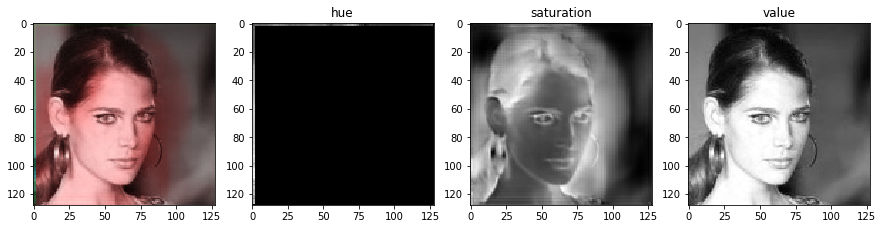

In [17]:
print('countEpochs',countEpochs)
predictions()


In [ ]:
def nonMlBaseline():
    x = training_generator[33][0][0,...,0]
    y = np.dstack([params['mean'][...,0].astype('uint8'), params['mean'][...,1].astype('uint8'), x.astype('uint8')])
    #print(y.shape, params['mean'][...,0].min(), params['mean'][...,0].max(), x.dtype, x.min(), x.max())
    # plt.imshow(x - params['mean'][...,2])
    fig = plt.figure(figsize=(8,8))
    for i in range(1,4):
        fig.add_subplot(1,3,i)
        plt.title(['hue','saturation','value'][i-1])
        plt.imshow(params['mean'][...,i-1])
    plt.show()
    print("Input value with mean hue and mean saturation:")
    showHsv(y)
nonMlBaseline()

In [ ]:
import tensorflow.keras.backend as K

def customLoss(yTrue, yPred):
    # cyclic loss
    hueTrue = yTrue[...,0]
    huePred = yPred[...,0]
    maxHue = 180
    hue = K.minimum(K.square(huePred - hueTrue), 
                    K.minimum(K.square(huePred - hueTrue + maxHue), 
                              K.square(huePred - hueTrue - maxHue)))
    
    satDiff = yPred[...,1] - yTrue[...,1]
    # double loss for undershooting saturation
    # if sign is + then mul is 2, if sign is - mul is 2
    mul1or2 = (-K.sign(satDiff) +1)/2 + 1
    saturation =  mul1or2*K.square(satDiff)
    #saturation = K.square(satDiff)
    return concatenate([hue, saturation], axis=-1)

print("testing custom Loss:")
x = Input(shape=(None,))
y = Input(shape=(None,))
loss_func = K.function([x, y], [customLoss(x, y)])
loss_func([[[[1,1], [1,16] ]], [[[1,1], [1,14]]] ])

OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255
179.0 0.0
(64, 128, 128, 2)


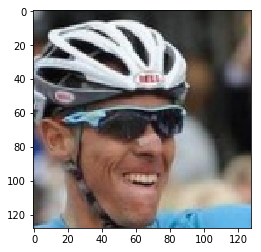

0 179


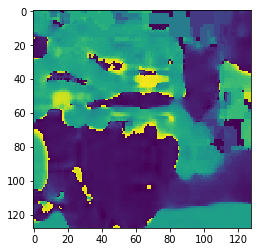

In [66]:
print("OpenCV uses H: 0 - 180, S: 0 - 255, V: 0 - 255")
batch=55
print(training_generator[batch][1][...,0].max(), training_generator[batch][1][...,0].min())
print(training_generator[batch][1].shape)
h = np.minimum(training_generator[batch][1][0,..., 0 ] + 0, 180).astype('uint8') 
s = np.minimum(training_generator[batch][1][0,..., 1 ] + 0, 255).astype('uint8')
v = training_generator[batch][0][0,...].astype('uint8')
y = np.dstack([h , s, v ] )
showHsv(y )
print(h.min(), h.max())
plt.imshow(h)

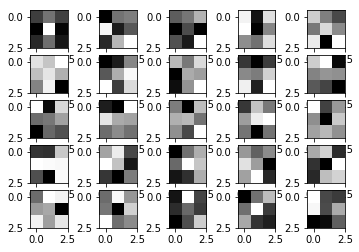

In [67]:
x1w = model.get_weights()[0][:,:,0,:]
for i in range(1,26):
  plt.subplot(5,5,i)
  plt.imshow(x1w[:,:,i],interpolation="nearest",cmap="gray")
plt.show()